In [1]:
from google.colab import files

# Subir archivo JSON
uploaded = files.upload()

Saving crypto_db.crypto_data2.json to crypto_db.crypto_data2.json


In [2]:
from pyspark.sql import SparkSession

# Inicializar sesión de Spark
spark = SparkSession.builder \
    .appName("Crypto Analysis") \
    .getOrCreate()

# Leer el archivo JSON
df = spark.read.option("multiline", "true").json("crypto_db.crypto_data2.json")

# Mostrar primeras filas
df.show(5, truncate=False)

# Esquema del DataFrame
df.printSchema()

+--------------------------+-----------+-------+--------------------------+
|_id                       |currency   |price  |timestamp                 |
+--------------------------+-----------+-------+--------------------------+
|{673c78c33f89a1dd8287c3fb}|Binancecoin|617.17 |2024-11-19T11:38:43.122457|
|{673c78c33f89a1dd8287c3fc}|Bitcoin    |91659.0|2024-11-19T11:38:43.144313|
|{673c78c33f89a1dd8287c3fd}|Ethereum   |3119.0 |2024-11-19T11:38:43.146319|
|{673c78cd3f89a1dd8287c3fe}|Binancecoin|617.17 |2024-11-19T11:38:53.519422|
|{673c78cd3f89a1dd8287c3ff}|Bitcoin    |91659.0|2024-11-19T11:38:53.520960|
+--------------------------+-----------+-------+--------------------------+
only showing top 5 rows

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- price: double (nullable = true)
 |-- timestamp: string (nullable = true)



In [3]:
from pyspark.sql.functions import col

# Seleccionar columnas y aplanar el campo _id
df = df.select(
    col("currency"),
    col("price"),
    col("timestamp"),
    col("_id.$oid").alias("id")
)

# Mostrar primeras filas
df.show(5, truncate=False)

+-----------+-------+--------------------------+------------------------+
|currency   |price  |timestamp                 |id                      |
+-----------+-------+--------------------------+------------------------+
|Binancecoin|617.17 |2024-11-19T11:38:43.122457|673c78c33f89a1dd8287c3fb|
|Bitcoin    |91659.0|2024-11-19T11:38:43.144313|673c78c33f89a1dd8287c3fc|
|Ethereum   |3119.0 |2024-11-19T11:38:43.146319|673c78c33f89a1dd8287c3fd|
|Binancecoin|617.17 |2024-11-19T11:38:53.519422|673c78cd3f89a1dd8287c3fe|
|Bitcoin    |91659.0|2024-11-19T11:38:53.520960|673c78cd3f89a1dd8287c3ff|
+-----------+-------+--------------------------+------------------------+
only showing top 5 rows



In [4]:
# Importación de la función to_timestamp desde PySpark
from pyspark.sql.functions import to_timestamp

# Convertir la columna 'timestamp' de tipo string a un formato de fecha y hora
df = df.withColumn("timestamp", to_timestamp("timestamp"))

# Mostrar primeras filas procesadas
df.show(5, truncate=False)

+-----------+-------+--------------------------+------------------------+
|currency   |price  |timestamp                 |id                      |
+-----------+-------+--------------------------+------------------------+
|Binancecoin|617.17 |2024-11-19 11:38:43.122457|673c78c33f89a1dd8287c3fb|
|Bitcoin    |91659.0|2024-11-19 11:38:43.144313|673c78c33f89a1dd8287c3fc|
|Ethereum   |3119.0 |2024-11-19 11:38:43.146319|673c78c33f89a1dd8287c3fd|
|Binancecoin|617.17 |2024-11-19 11:38:53.519422|673c78cd3f89a1dd8287c3fe|
|Bitcoin    |91659.0|2024-11-19 11:38:53.52096 |673c78cd3f89a1dd8287c3ff|
+-----------+-------+--------------------------+------------------------+
only showing top 5 rows



In [5]:
import pandas as pd

# Filtrar datos de Binancecoin
binancecoin_df = df.filter(df.currency == "Binancecoin").select("timestamp", "price")

# Convertir a DataFrame
binancecoin_data = binancecoin_df.toPandas()

# Renombrar las columnas
binancecoin_data = binancecoin_data.rename(columns={"timestamp": "ds", "price": "y"})
binancecoin_data["ds"] = pd.to_datetime(binancecoin_data["ds"])

# Mostrar las primeras filas del DataFrame para verificar los datos
print(binancecoin_data.head())

                          ds       y
0 2024-11-19 11:38:43.122457  617.17
1 2024-11-19 11:38:53.519422  617.17
2 2024-11-19 11:39:03.922474  617.17
3 2024-11-19 11:39:14.313473  617.17
4 2024-11-19 11:39:24.778449  617.17


In [6]:
# Importación de la prueba Dickey-Fuller para evaluar la estacionariedad
from statsmodels.tsa.stattools import adfuller

# Verificar estacionariedad de la serie de Binancecoin
adf_test_binance = adfuller(binancecoin_data["y"])      # 'y' contiene los datos de precios de Binancecoin
print(f"ADF Statistic: {adf_test_binance[0]}")          # Estadístico ADF
print(f"p-value: {adf_test_binance[1]}")                # Valor p asociado

# Decidir si la serie es estacionaria según el valor p
if adf_test_binance[1] > 0.05:
    print("La serie no es estacionaria. Aplicando diferenciación...")
    binancecoin_data_diff = binancecoin_data["y"].diff().dropna()         # Diferenciación para eliminar tendencias
else:
    print("La serie es estacionaria.")
    binancecoin_data_diff = binancecoin_data["y"]                         # No se realiza diferenciación


ADF Statistic: -2.425158165491486
p-value: 0.134761228545474
La serie no es estacionaria. Aplicando diferenciación...


In [7]:
# Se realiza una segunda prueba para confirmar que la serie diferenciada es estacionaria
adf_test_diff_binance = adfuller(binancecoin_data_diff)
print(f"ADF Statistic (diferenciada): {adf_test_diff_binance[0]}")
print(f"p-value (diferenciada): {adf_test_diff_binance[1]}")

if adf_test_diff_binance[1] <= 0.05:
    print("La serie ahora es estacionaria.")
else:
    print("La serie todavía no es estacionaria.")


ADF Statistic (diferenciada): -23.122468348786818
p-value (diferenciada): 0.0
La serie ahora es estacionaria.


In [8]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Cada tupla (p, d, q) representa los parámetros del modelo ARIMA:
# p: número de términos autoregresivos (AR)
# d: número de diferenciaciones necesarias para estacionariedad (diferencias)
# q: número de términos de media móvil (MA)

# Lista de parámetros a probar
param_list = [(2, 1, 2), (5, 2, 1), (0, 2, 2), (3, 1, 3), (4, 2, 0)]

# Diccionario para almacenar resultados
results = {}

# Probar diferentes configuraciones
for params in param_list:
    print(f"Test ARIMA{params}...")
    try:
        # Ajustar el modelo ARIMA
        model = ARIMA(binancecoin_data_diff, order=params)
        model_fit = model.fit()

        # Calcular métricas
        mae = mean_absolute_error(binancecoin_data_diff, model_fit.fittedvalues)
        rmse = np.sqrt(mean_squared_error(binancecoin_data_diff, model_fit.fittedvalues))

        # Guardar resultados
        results[params] = {
            "MAE": mae,
            "RMSE": rmse,
            "AIC": model_fit.aic,
            "BIC": model_fit.bic
        }

        # Imprimir resultados del modelo actual
        print(f"ARIMA{params}: MAE={mae:.2f}, RMSE={rmse:.2f}, AIC={model_fit.aic:.2f}, BIC={model_fit.bic:.2f}")

    # Mostrar errores si el modelo no puede ser ajustado con los parámetros actuales
    except Exception as e:
        print(f"Error con ARIMA{params}: {e}")

# Selección del mejor modelo basado en AIC
best_params = min(results, key=lambda x: results[x]["AIC"])
print(f"\nMejor modelo para Binance Coin: ARIMA{best_params}")
print(f"Resultados: {results[best_params]}")

Test ARIMA(2, 1, 2)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2): MAE=0.06, RMSE=0.30, AIC=4490.88, BIC=4527.33
Test ARIMA(5, 2, 1)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

ARIMA(5, 2, 1): MAE=0.11, RMSE=0.32, AIC=6169.16, BIC=6220.19
Test ARIMA(0, 2, 2)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(0, 2, 2): MAE=0.07, RMSE=0.30, AIC=4575.10, BIC=4596.97
Test ARIMA(3, 1, 3)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

ARIMA(3, 1, 3): MAE=0.06, RMSE=0.30, AIC=4493.18, BIC=4544.21
Test ARIMA(4, 2, 0)...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA(4, 2, 0): MAE=0.16, RMSE=0.41, AIC=11246.47, BIC=11282.92

Mejor modelo para Binance Coin: ARIMA(2, 1, 2)
Resultados: {'MAE': 0.05617150320545853, 'RMSE': 0.2975127319352346, 'AIC': 4490.876764309547, 'BIC': 4527.327141009522}


In [11]:
# Remuestreo de los datos a intervalos de 1 minuto
binancecoin_data_resampled = (
    binancecoin_data.set_index("ds")        # Establecer el índice
    .resample("T")                          # 'T' para remuestrear a minutos
    .mean()                                 # Calcular el promedio por intervalo
    .dropna()                               # Eliminar valores nulos
    .reset_index()                          # Reiniciar el índice para su posterior uso
)

# Configurar nuevamente la columna "ds" como índice
binancecoin_data_resampled = binancecoin_data_resampled.set_index('ds')

# Verificar el resultado
print(binancecoin_data_resampled.head())

                          y
ds                         
2024-11-19 11:38:00  617.17
2024-11-19 11:39:00  617.17
2024-11-19 11:40:00  617.17
2024-11-19 11:41:00  617.17
2024-11-19 11:42:00  617.17


<ipython-input-11-8374e0439b7b>:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample("T")                          # 'T' para remuestrear a minutos


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10831
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2240.438
Date:                Wed, 18 Dec 2024   AIC                           4490.877
Time:                        19:18:21   BIC                           4527.327
Sample:                             0   HQIC                          4503.166
                              - 10831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9861      0.068    -14.452      0.000      -1.120      -0.852
ar.L2         -0.0041      0.049     -0.083      0.934      -0.101       0.093
ma.L1         -0.0164      0.039     -0.419      0.6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
<ipython-input-12-e2946972c5b0>:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  forecast_index_bnb = pd.date_range(start=binancecoin_data_resampled.index[-1], periods=forecast_steps_bnb + 1, freq='T')[1:]


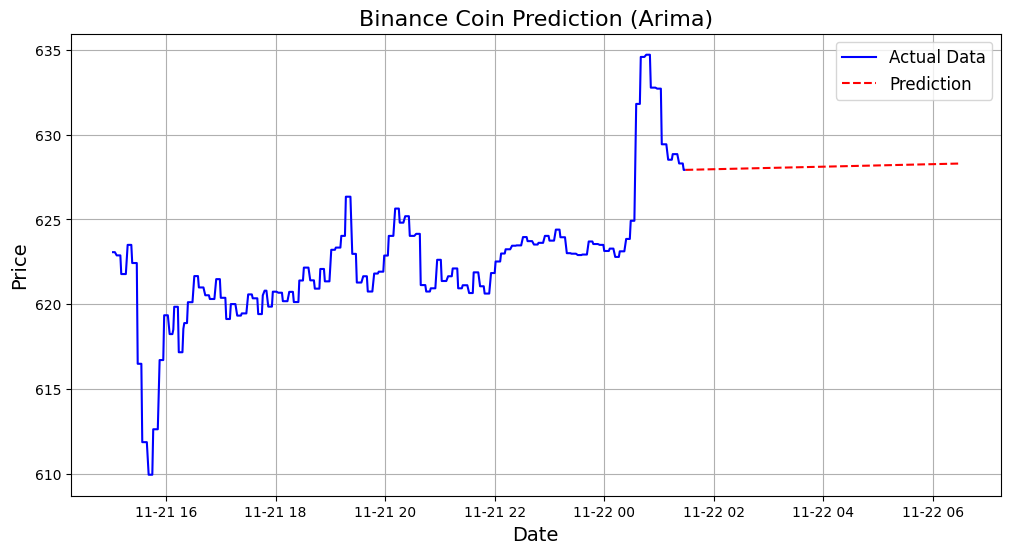

In [12]:
import matplotlib.pyplot as plt

# Ajustar el modelo ARIMA(2, 1, 2) PARA BinanceCoin
model = ARIMA(binancecoin_data_diff, order=(2, 1, 2))
model_fit = model.fit()

# Mostrar el resumen del modelo
# información estadística detallada sobre los parámetros ajustados,
# como coeficientes, errores estándar, valores AIC/BIC, y residuales
print(model_fit.summary())

# Generar predicciones
forecast_steps_bnb = 300  # Número de pasos a predecir
forecast_bnb = model_fit.forecast(steps=forecast_steps_bnb)

# Crear índice para las predicciones
forecast_index_bnb = pd.date_range(start=binancecoin_data_resampled.index[-1], periods=forecast_steps_bnb + 1, freq='T')[1:]

# Ajustar las predicciones para volver a los valores originales
forecast_cumsum_bnb = forecast_bnb.cumsum() + binancecoin_data_resampled['y'].iloc[-1]

# Convertir predicciones a DataFrame
forecast_df_bnb = pd.DataFrame({'ds': forecast_index_bnb, 'y_pred': forecast_cumsum_bnb})

# Visualización de los resultados
plt.figure(figsize=(12, 6))
plt.plot(binancecoin_data_resampled.index[-500:], binancecoin_data_resampled['y'][-500:], label='Actual Data', color='blue')
plt.plot(forecast_df_bnb['ds'], forecast_df_bnb['y_pred'], label='Prediction', color='red', linestyle='--')
plt.title('Binance Coin Prediction (Arima)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()